In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verify dataset path (adjust if your folder is nested differently)
import os
dataset_path = '/content/drive/MyDrive/btumordataset'
print("Dataset exists:", os.path.exists(dataset_path))

# List contents to confirm structure
print("Dataset contents:", os.listdir(dataset_path))

Mounted at /content/drive
Dataset exists: True
Dataset contents: ['Training', 'Testing']


In [ ]:
# Install required libraries
!pip install torch torchvision opencv-python

# Import libraries
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import numpy as np

# Define dataset path
dataset_path = '/content/drive/MyDrive/btumordataset'

# Define transformations for training and testing
# ResNet50 expects 224x224 RGB images, so we convert grayscale MRIs to 3 channels
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224 for ResNet50
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),  # Convert to tensor (3 channels by default)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Load datasets
image_datasets = {
    x: ImageFolder(os.path.join(dataset_path, x), transform=data_transforms[x])
    for x in ['Training', 'Testing']
}

# Create dataloaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['Training', 'Testing']
}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

# Print information
print("Dataset sizes:", dataset_sizes)
print("Class names:", class_names)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Import additional libraries
import torch.nn as nn
import torch.optim as optim

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet50
model = torchvision.models.resnet50(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 classes: glioma, meningioma, notumor, pituitary

# Move model to GPU if available
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only optimize the final layer

# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Set model to training mode
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over training data
        for inputs, labels in dataloaders['Training']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes['Training']
        epoch_acc = running_corrects.double() / dataset_sizes['Training']

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print("Training complete!")
    return model

# Train the model
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)

Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.5MB/s]


Epoch 1/5
----------
Training Loss: 0.5847 Acc: 0.7857
Epoch 2/5
----------
Training Loss: 0.3948 Acc: 0.8582
Epoch 3/5
----------
Training Loss: 0.3494 Acc: 0.8748
Epoch 4/5
----------
Training Loss: 0.3089 Acc: 0.8860
Epoch 5/5
----------
Training Loss: 0.2964 Acc: 0.8920
Training complete!


Test Accuracy: 0.8841
Test Precision: 0.8822
Test Recall: 0.8841
Test F1-Score: 0.8818


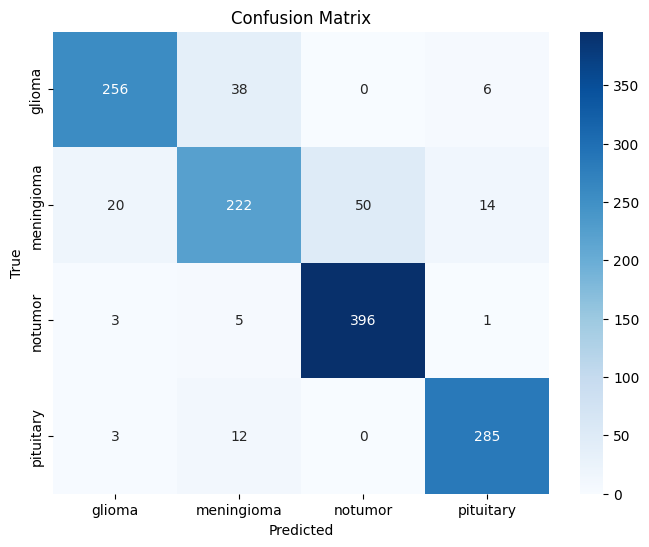

In [ ]:
# Import additional libraries for metrics and plotting
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluation function
def evaluate_model(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient computation for evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print metrics
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1, cm

# Evaluate the model
accuracy, precision, recall, f1, cm = evaluate_model(model, dataloaders['Testing'], class_names)

Class weights: tensor([1.0810, 1.0665, 0.8953, 0.9801], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
Training Loss: 0.2416 Acc: 0.9202
Epoch 2/10
----------
Training Loss: 0.1043 Acc: 0.9655
Epoch 3/10
----------
Training Loss: 0.0659 Acc: 0.9795
Epoch 4/10
----------
Training Loss: 0.0280 Acc: 0.9916
Epoch 5/10
----------
Training Loss: 0.0158 Acc: 0.9960
Epoch 6/10
----------
Training Loss: 0.0162 Acc: 0.9947
Epoch 7/10
----------
Training Loss: 0.0113 Acc: 0.9977
Epoch 8/10
----------
Training Loss: 0.0088 Acc: 0.9981
Epoch 9/10
----------
Training Loss: 0.0129 Acc: 0.9967
Epoch 10/10
----------
Training Loss: 0.0096 Acc: 0.9982
Training complete!
Test Accuracy: 0.9962
Test Precision: 0.9962
Test Recall: 0.9962
Test F1-Score: 0.9962


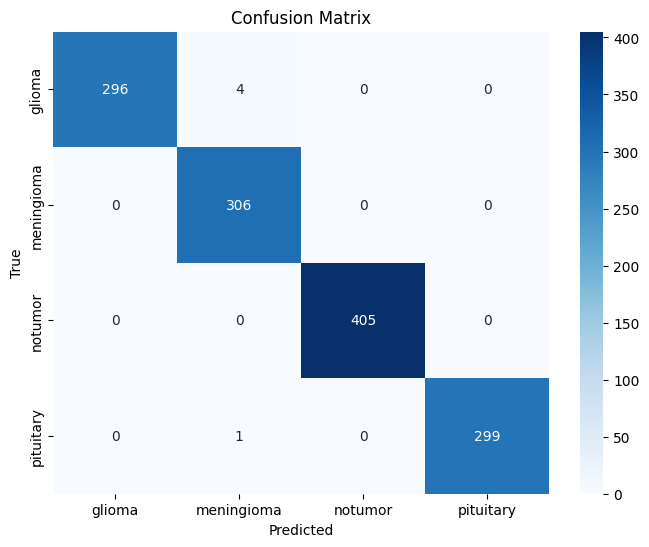

In [ ]:
# Import additional libraries
from torch.optim.lr_scheduler import StepLR

# Enhanced data augmentation for training
data_transforms['Training'] = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Add rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Add brightness/contrast adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Reload training dataloader with new transforms
image_datasets['Training'] = ImageFolder(os.path.join(dataset_path, 'Training'), transform=data_transforms['Training'])
dataloaders['Training'] = DataLoader(image_datasets['Training'], batch_size=32, shuffle=True, num_workers=2)

# Compute class weights to handle imbalance
from collections import Counter
train_labels = [label for _, label in image_datasets['Training']]
class_counts = Counter(train_labels)
total_samples = len(train_labels)
class_weights = torch.tensor([total_samples / (len(class_names) * class_counts[i]) for i in range(len(class_names))], dtype=torch.float)
class_weights = class_weights.to(device)
print("Class weights:", class_weights)

# Reload ResNet50 and unfreeze more layers
model = torchvision.models.resnet50(pretrained=True)

# Unfreeze the last two blocks (layer4 and fc)
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Modify the final layer again
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

# Define loss function with class weights and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)  # Lower LR for fine-tuning
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce LR by 10x every 3 epochs

# Updated training function with scheduler
def train_model_optimized(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders['Training']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()  # Update learning rate

        epoch_loss = running_loss / dataset_sizes['Training']
        epoch_acc = running_corrects.double() / dataset_sizes['Training']
        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print("Training complete!")
    return model

# Train the optimized model
model = train_model_optimized(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10)

# Re-evaluate the model
accuracy, precision, recall, f1, cm = evaluate_model(model, dataloaders['Testing'], class_names)

Model saved to /content/drive/MyDrive/btumordataset/resnet50_tumor_model.pth


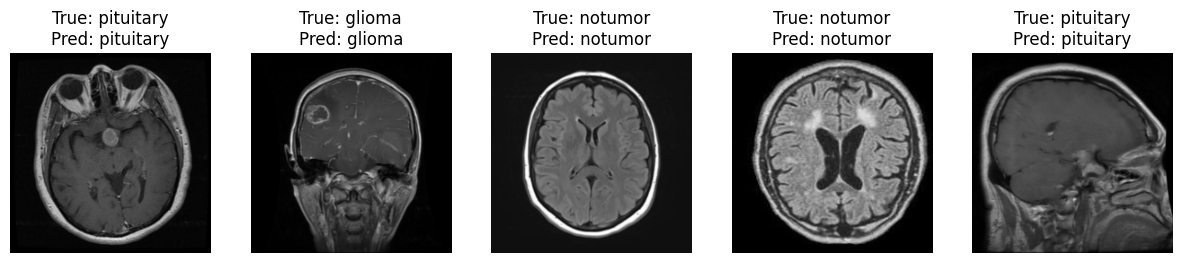

In [ ]:
# Save the model to Google Drive
model_path = '/content/drive/MyDrive/btumordataset/resnet50_tumor_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Visualize predictions on a few test images
import matplotlib.pyplot as plt
from PIL import Image

# Set model to evaluation mode
model.eval()

# Get a few test images
test_loader = dataloaders['Testing']
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Make predictions
with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Denormalize images for display
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
images = images.cpu() * std + mean
images = images.clamp(0, 1)

# Plot 5 images with true and predicted labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()  # Convert to HWC for plotting
    axes[i].imshow(img)
    true_label = class_names[labels[i]]
    pred_label = class_names[preds[i]]
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
    axes[i].axis('off')
plt.show()